In [3]:
# Packages

import pandas as pd
import pickle
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import shutil
import re

VEXT_STR_XXX.pkl --> ORDNER Vext_XXX

In [2]:
# Basisordner mit allen Vext_*.pkl Dateien
base_dir = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP_64grid_swing/"

# Regex-Muster: Vext_<STR>_<TEMP>.pkl
pattern = re.compile(r"^Vext_([A-Z]{3})_(\d+)\.pkl$")

# Alle Dateien im Basisordner durchgehen
for filename in os.listdir(base_dir):
    if not filename.endswith(".pkl"):
        continue

    match = pattern.match(filename)
    if not match:
        print(f"⚠️  Übersprungen (kein passender Name): {filename}")
        continue

    structure, temp = match.groups()
    temp_folder = f"Vext_{temp}"  # z. B. "Vext_400"
    temp_path = os.path.join(base_dir, temp_folder)

    # Ordner erstellen, falls nicht vorhanden
    os.makedirs(temp_path, exist_ok=True)

    # Pfade für Verschieben
    src = os.path.join(base_dir, filename)
    dst = os.path.join(temp_path, filename)

    # Datei verschieben
    shutil.move(src, dst)
    

print("Alle Dateien wurden nach Temperatur-Unterordnern sortiert.")


Alle Dateien wurden nach Temperatur-Unterordnern sortiert.


MIN/MAX GLOBAL PICKEL

In [28]:
import os
import pickle
import numpy as np

# Basisordner mit den Unterordnern (z. B. Vext_400/, Vext_500/, ...)
base_dir = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP_32grid"

global_min = np.inf
global_max = -np.inf
count_files = 0

# Alle Unterordner durchlaufen
for folder in os.listdir(base_dir):
    temp_path = os.path.join(base_dir, folder)
    if not (os.path.isdir(temp_path) and folder.startswith("Vext_")):
        continue

    #print(f"\n📂 Verarbeite {folder} ...")

    # Alle .pkl-Dateien in diesem Ordner
    for filename in os.listdir(temp_path):
        if not filename.endswith(".pkl"):
            continue

        file_path = os.path.join(temp_path, filename)

        # Datei laden
        with open(file_path, "rb") as f:
            data = pickle.load(f)

        # In NumPy-Array umwandeln
        arr = np.asarray(data, dtype=np.float64).squeeze()

        # NaN/Inf entfernen
        arr = arr[np.isfinite(arr)]
        if arr.size == 0:
            continue

        # Lokales Min/Max
        local_min = arr.min()
        local_max = arr.max()

        # Globales Min/Max aktualisieren
        global_min = min(global_min, local_min)
        global_max = max(global_max, local_max)
        count_files += 1

        #print(f"  ✅ {filename}: min={local_min:.3f}, max={local_max:.3f}")

# Gesamtergebnis
if count_files > 0:
    print(f"\n✅ {count_files} Dateien verarbeitet")
    print(f"🌡️  Globales Minimum: {global_min:.3f}")
    print(f"🌡️  Globales Maximum: {global_max:.3f}")
else:
    print("⚠️ Keine .pkl-Dateien gefunden.")



✅ 4655 Dateien verarbeitet
🌡️  Globales Minimum: -14.288
🌡️  Globales Maximum: 10.000


VISUALISIERUNG VEXT RAW

(1, 64, 64, 64)
(262144,)


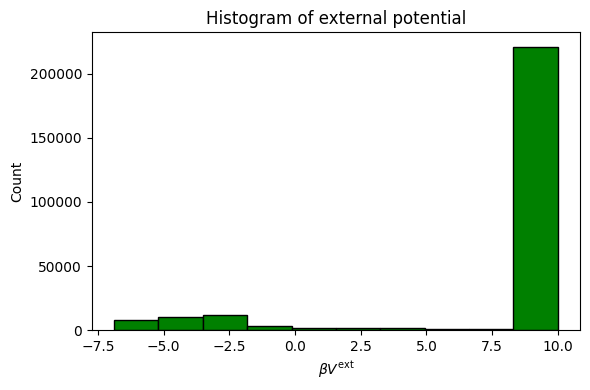

In [24]:
with open("/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP/Vext_400/Vext_MWW_400.pkl", "rb") as f:
    data = pickle.load(f)


cutoff = 10.1
mask = data < cutoff
data = jnp.array(data)
#data = np.exp(-data)
data_mask = data[mask]
print(data.shape)
print(data_mask.shape)

plt.figure(figsize=(6,4))
plt.hist(data_mask, bins=10, color="green", edgecolor="black")
plt.xlabel(r"$\beta V^{\mathrm{ext}}$")
plt.ylabel("Count")
#plt.ylim(0, 100000)
plt.title(f"Histogram of external potential")
plt.tight_layout()
plt.savefig(
    "beta_Vext_histogram_example_MWW2.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

VEXT HIST

In [ ]:
import os
import re
import pickle
import numpy as np
import pandas as pd

VEXT_MAX = 10.1       # cutoff oben
VEXT_MIN = -15     # cutoff unten global "-14.744"
N_BINS   = 100

base_dir = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP"
pattern  = re.compile(r"Vext_([A-Z]{3})_(\d+)\.pkl")

all_dfs = []
counter = 0
# temp ordner iterieren
for temp_folder in os.listdir(base_dir):
    temp_path = os.path.join(base_dir, temp_folder)
    if not (os.path.isdir(temp_path) and temp_folder.startswith("Vext_")):
        continue

    print(f"\nBearbeite Temperatur-Ordner: {temp_folder}")
    rows = []

    # alle pickle daten
    for filename in os.listdir(temp_path):
        if not filename.endswith(".pkl"):
            continue

        m = pattern.match(filename)
        if not m:
            print(f"Übersprungen (kein gültiger Name): {filename}")
            continue

        struct_name, temp = m.groups()
        file_path = os.path.join(temp_path, filename)

        # Entpickeln
        with open(file_path, "rb") as f:
            data = pickle.load(f)

        arr = np.asarray(data, dtype=np.float64).squeeze()
        arr = arr[np.isfinite(arr)]  # NaN/Inf entfernen

        if arr.size != 32**3:
            counter += 1
        print(counter)

        # Mask und exp(-)
        if arr.size == 0:
            hist = np.zeros(N_BINS, dtype=int)
            edges = np.linspace(0, 1, N_BINS + 1)
        else:
            #arr = np.clip(arr, VEXT_MIN, VEXT_MAX)
            #arr_exp = np.exp(-arr)
            hist, edges = np.histogram(arr, bins=N_BINS, range=(VEXT_MIN, VEXT_MAX)) # automatisch äquistante bins

        # struktur
        entry = {"structure": struct_name, "temperature": int(temp)}
        entry.update({f"bin_{i}": int(v) for i, v in enumerate(hist)})
        entry["x_min"] = float(edges[-1])
        entry["x_max"] = float(edges[0])
        rows.append(entry)

    # -
    if rows:
        df_temp = pd.DataFrame(rows)
        all_dfs.append(df_temp)
        print(f"{len(rows)} Strukturen verarbeitet")

# df_all zusammenführen
df_all = pd.concat(all_dfs, ignore_index=True) if all_dfs else pd.DataFrame()
print(f"\n Gesamt-DataFrame mit {len(df_all)} Zeilen erstellt")

# csv
out_name = f"Vext_allTEMP_noexp_rangelinBin_cut{VEXT_MAX}_{VEXT_MIN}_{N_BINS}Bins.csv"
out_path = os.path.join(base_dir, out_name)
df_all.to_csv(out_path, index=False)

print(f"Datei gespeichert unter:\n{out_path}")


Bearbeite Temperatur-Ordner: Vext_400
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
245 Strukturen verarbeitet

Bearbeite Temperatur-Ordner: Vext_650
246
247
248
249
250
251

ANALYSE HIST

KeyError: 'temperature'

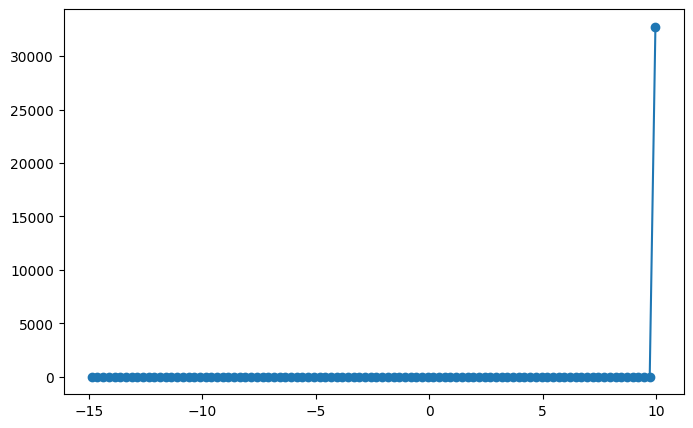

In [47]:
df = pd.read_csv("/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP_32grid/Vext_allTEMP_noexp_rangelinBin_cut10.1_-15_100Bins_32grid.csv")

#min_val = df["bin_2"].min()
#max_val = df["bin_2"].max()

structure = "BCT"

# Zeilen dieser Struktur auswählen (falls mehrere Temperaturen vorhanden sind)
#df_sel = df[df["structure"] == structure]

# Wenn du nur eine bestimmte Temperatur willst:
df_sel = df[(df["structure_name"] == structure) & (df["temperature_kelvin"] == 300)]

# Sicherstellen, dass überhaupt Daten da sind
if df_sel.empty:
    raise ValueError(f"Keine Daten für Struktur {structure} gefunden!")

# Wir nehmen hier die erste Zeile (z. B. Temperatur 400)
row = df_sel.iloc[0]

# Histogrammdaten extrahieren
bin_cols = [c for c in df.columns if c.startswith("bin_")]
y = row[bin_cols].values

# x-Achse rekonstruieren (gleichmäßig zwischen x_min und x_max)
x_max = row["x_min"]
x_min = row["x_max"]
x_edges = np.linspace(x_min, x_max, len(bin_cols) + 1)
x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])  # Mitten der Bins

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x_centers, y, marker="o", lw=1.5)
#plt.xlim(-15,9)
#plt.ylim(0, 4000)
plt.title(f"Histogramm für Struktur {structure} (Temp {int(row['temperature'])} K)")
plt.xlabel("Vext (x)")
plt.ylabel("Häufigkeit / Bin")
plt.grid(True)
plt.tight_layout()
plt.show()


DFT - CLEAN

In [ ]:
# Features Entfernen

dft_data = pd.read_csv("/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/2025_10_5_DB_100Bins_DOTO.csv")

dft_data = dft_data.loc[:, ~dft_data.columns.str.isdigit()]

output_path = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/DFT_Data_clean_06_10.csv"
dft_data.to_csv(output_path, index=False)

In [ ]:
# Klammern entfernen

df = pd.read_csv("/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/DFT_Data_clean_06_10.csv")

df["density_bulk"] = pd.to_numeric(
    df["density_bulk"].astype(str)
      .str.replace(r"^\s*\[\s*", "", regex=True)  # führende '[' entfernen
      .str.replace(r"\s*\]\s*$", "", regex=True)  # schließende ']' entfernen
      .str.strip(),
    errors="coerce"
)

print(df["density_bulk"].head(), df["density_bulk"].dtype)  # sollte float64 sein


#df["density_bulk"].values

df.to_csv("/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/DFT_Data_clean_06_10.csv", index=False)